In [1]:
import os
import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout
from scikeras.wrappers import KerasClassifier 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from skimage.feature import hog
from skimage import exposure
from skimage import color
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [2]:
data_path = "data/train"

In [4]:
# Function to extract HOG features from an image
def extract_hog_features(image):
    # Convert RGB to Grayscale for each channel
    channel_hogs = []
    for channel in range(image.shape[2]):
        channel_image = image[:, :, channel]
        
        # HOG parameters
        win_size = (64, 64)
        block_size = (16, 16)
        block_stride = (4, 4)
        cell_size = (8, 8)
        nbins = 9
        
        # Calculate HOG features for each channel
        hog_descriptor = hog(channel_image, orientations=nbins, pixels_per_cell=cell_size, cells_per_block=(1, 1))
        channel_hogs.extend(hog_descriptor)
    
    return channel_hogs
# Load and preprocess data
X, y, images = [], [], []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        
        # Extract HOG features
        hog_features = extract_hog_features(image)
        
        # Append features and labels
        X.append(hog_features)
        y.append(class_folder)
        images.append(image)

X = np.array(X)
y = np.array(y)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize HOG features
X = X / np.max(X, axis=1)[:, None]

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(
    X, y_encoded, images, test_size=0.2, random_state=42
)


In [5]:
print("Label :",len(os.listdir(data_path)))
print("Label Description :",os.listdir(data_path))
# Print the number of loaded images
total_images_loaded = len(images)
print(f"Total number of loaded images: {total_images_loaded}")

Label : 6
Label Description : ['Bitter_Gourd', 'Broccoli', 'Cabbage', 'Carrot', 'Cucumber', 'Radish']
Total number of loaded images: 6091


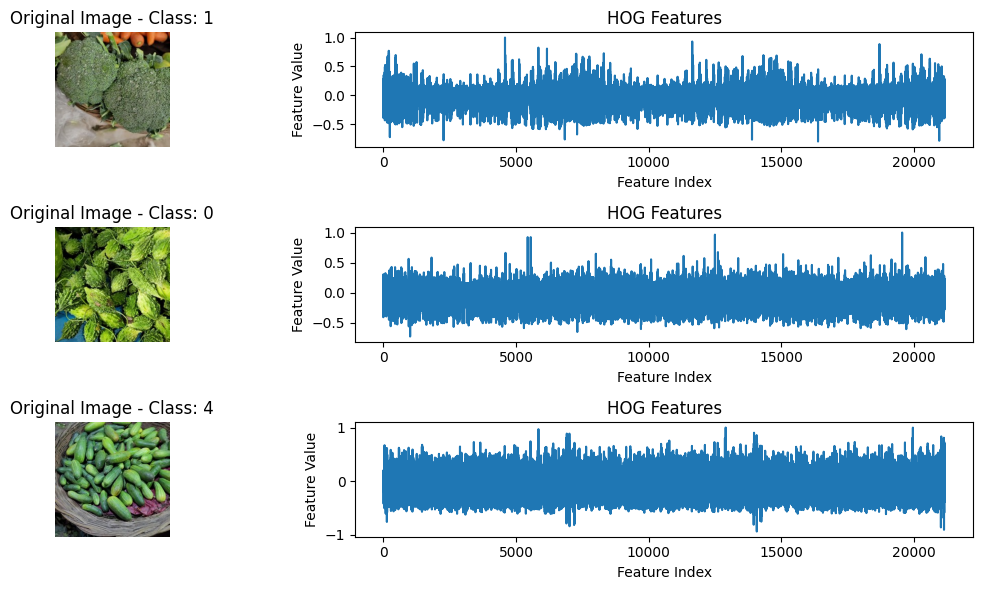

In [12]:

num_images_to_visualize = 3
fig, axs = plt.subplots(num_images_to_visualize, 2, figsize=(12, 2 * num_images_to_visualize))

for i in range(num_images_to_visualize):
    # Display the original image
    axs[i, 0].imshow(images_train[i][:, :, ::-1])  # OpenCV uses BGR, matplotlib uses RGB
    axs[i, 0].set_title(f"Original Image - Class: {y_train[i]}")
    axs[i, 0].axis("off")

    # Display the HOG representation
    axs[i, 1].plot(X_train[i])
    axs[i, 1].set_title("HOG Features")
    axs[i, 1].set_xlabel("Feature Index")
    axs[i, 1].set_ylabel("Feature Value")

plt.tight_layout()
plt.show()

In [29]:

# Function to create the model with a variable number of dense units
def create_model(dense_units=128, learning_rate=0.001, dropout_rate=0.5):
    optimizer = Adam(learning_rate=learning_rate)
    model = Sequential([
        Dense(dense_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(rate=dropout_rate),
        Dense(96, activation='relu'),
        Dropout(rate=dropout_rate),
        Dense(6, activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the parameter grid for random search
param_dist = {
    'batch_size': [32],
    'epochs': [10,20,30],
    'optimizer': ['adam','rmsprop'],
    'optimizer__learning_rate': [0.0001,0.001, 0.01],
    'model__dense_units': [64, 100, 128],
    'model__dropout_rate': [0.2, 0.5]  # Update the parameter name
}

# Create KerasClassifier
keras_model = KerasClassifier(model=create_model, verbose=0)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(keras_model, param_distributions=param_dist, scoring="accuracy", n_iter=10, cv=5, verbose=2, return_train_score=True)
random_search_result = random_search.fit(X_train, y_train)

print("Best Parameters: ", random_search_result.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END batch_size=32, epochs=30, model__dense_units=64, model__dropout_rate=0.2, optimizer=rmsprop, optimizer__learning_rate=0.0001; total time= 1.3min
[CV] END batch_size=32, epochs=30, model__dense_units=64, model__dropout_rate=0.2, optimizer=rmsprop, optimizer__learning_rate=0.0001; total time= 1.2min
[CV] END batch_size=32, epochs=30, model__dense_units=64, model__dropout_rate=0.2, optimizer=rmsprop, optimizer__learning_rate=0.0001; total time= 1.2min
[CV] END batch_size=32, epochs=30, model__dense_units=64, model__dropout_rate=0.2, optimizer=rmsprop, optimizer__learning_rate=0.0001; total time= 1.3min
[CV] END batch_size=32, epochs=30, model__dense_units=64, model__dropout_rate=0.2, optimizer=rmsprop, optimizer__learning_rate=0.0001; total time= 1.2min
[CV] END batch_size=32, epochs=10, model__dense_units=100, model__dropout_rate=0.5, optimizer=adam, optimizer__learning_rate=0.0001; total time=  47.6s
[CV] END batch_si

In [30]:
# Membuat DataFrame dari hasil pencarian grid
results_df = pd.DataFrame(random_search_result.cv_results_)

# Menampilkan kolom tertentu dari DataFrame
print(results_df[['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']])

# Menyimpan hasil ke file CSV
results_df.to_csv('bpnn_random_search_results_4.csv', index=False)

                                              params  mean_test_score  \
0  {'optimizer__learning_rate': 0.0001, 'optimize...         0.856935   
1  {'optimizer__learning_rate': 0.0001, 'optimize...         0.853244   
2  {'optimizer__learning_rate': 0.001, 'optimizer...         0.860222   
3  {'optimizer__learning_rate': 0.0001, 'optimize...         0.874385   
4  {'optimizer__learning_rate': 0.0001, 'optimize...         0.842367   
5  {'optimizer__learning_rate': 0.01, 'optimizer'...         0.864539   
6  {'optimizer__learning_rate': 0.0001, 'optimize...         0.856116   
7  {'optimizer__learning_rate': 0.01, 'optimizer'...         0.868430   
8  {'optimizer__learning_rate': 0.001, 'optimizer...         0.858990   
9  {'optimizer__learning_rate': 0.01, 'optimizer'...         0.848934   

   std_test_score  mean_train_score  std_train_score  
0        0.012492          0.999897     1.256954e-04  
1        0.009772          0.998563     8.368416e-04  
2        0.011882          0.99

In [31]:
# Train the best model
best_model = random_search_result.best_estimator_

Accuracy Testing: 0.8761279737489746
Accuracy Training: 0.9995894909688013


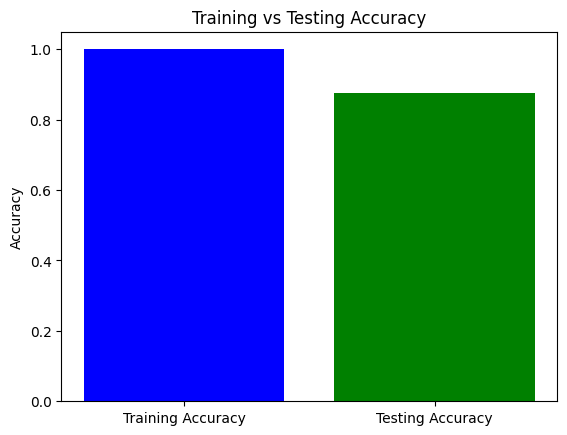

In [32]:
# Evaluate the model on the test set
accuracy_test = best_model.score(X_test, y_test)
print(f'Accuracy Testing: {accuracy_test}')
# Evaluate the model on the training set
accuracy_train = best_model.score(X_train, y_train)
print(f'Accuracy Training: {accuracy_train}')

# Plotting the comparison
labels = ['Training Accuracy', 'Testing Accuracy']
accuracies = [accuracy_train, accuracy_test]

plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.show()

# Menyimpan informasi ke dalam dictionary
data = {
    'Method': ['BackPropagation Neural Network'],
    'Best Param': [str(random_search_result.best_params_)],
    'Accuracy Training': [accuracy_train],
    'Accuracy Testing': [accuracy_test]
}

# Membuat DataFrame dari dictionary
df = pd.DataFrame(data)

# Menyimpan DataFrame ke dalam file CSV
df.to_csv('bpnn_model_evaluation_4.csv', index=False)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       217
           1       0.86      0.80      0.83       226
           2       0.87      0.87      0.87       208
           3       0.93      0.83      0.87       184
           4       0.91      0.91      0.91       183
           5       0.87      0.96      0.91       201

    accuracy                           0.88      1219
   macro avg       0.88      0.88      0.88      1219
weighted avg       0.88      0.88      0.88      1219



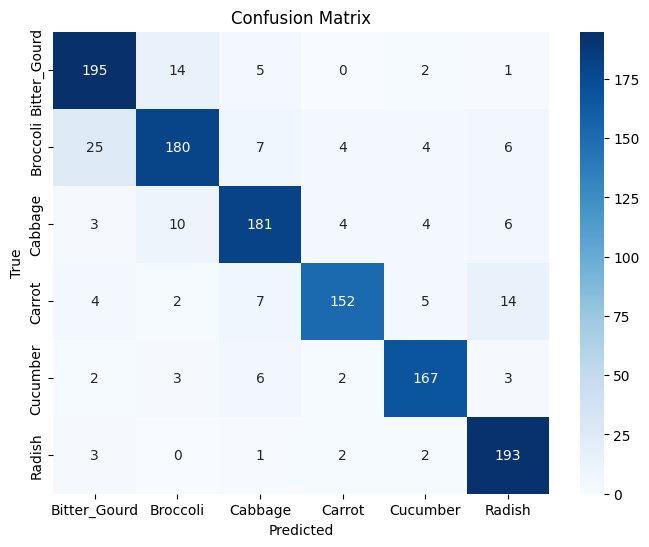

In [33]:
# Display the classification report
y_pred = best_model.predict(X_test)
print('Classification Report:')
print(classification_report(y_test, y_pred))

classification_rep = classification_report(y_test, y_pred, target_names=np.unique(y), output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()
classification_df.to_csv('classification_report_4.csv', index=False)
# Display the confusion matrix using Seaborn
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
# You may need to adjust the labels based on your actual class labels
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
